In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import pandas as pd
import matplotlib.pyplot as plt

import random
import sys, os
import multiprocessing

In [2]:
# use gpu for training if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/bizon/anaconda3/envs/torch_dev/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### Model specification

Possible training techiniques to apply:<br>
- Dropout: prevent from overfitting 
- Batch Normalization: accelerate the training of deep network

Some useful resources for batch normalization and dropout
- [note from Standord CS231n](https://cs231n.github.io/neural-networks-2/#reg): what is batch normalization and dropout
- [dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html): pytorch official document
- [nn.Dropout v.s. F.dropout](https://stackoverflow.com/questions/53419474/using-dropout-in-pytorch-nn-dropout-vs-f-dropout): nn.Dropout is generally preferred

In [3]:
class Multiple_layer_fc_network(nn.Module):
    def __init__(self, input_size, num_classes, 
                 apply_dropout=False, dropout_p=0.50, apply_bn=False):
        super(Multiple_layer_fc_network, self).__init__()
        self.apply_dropout = apply_dropout
        self.apply_bn = apply_bn
        
        if self.apply_dropout:
            print(f"apply dropout with dropping rate {dropout_p}")
        if self.apply_bn:
            print(f"apply batch normalization")
        
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, num_classes)
        self.bn1 = nn.BatchNorm1d(num_features=100)
        self.bn2 = nn.BatchNorm1d(num_features=50)
        self.dropout = nn.Dropout(p=dropout_p) # prob that the element to be zeroed
    
    def forward(self, x):
        # hidden layer 1
        x = self.fc1(x)
        if self.apply_bn:
            x = self.bn1(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)      
        # hidden layer 2
        x = self.fc2(x)
        if self.apply_bn:
            x = self.bn2(x)
        x = F.relu(x)
        if self.apply_dropout:
            x = self.dropout(x)   
        # output layer
        x = self.fc3(x)
        return x

### Dimensionality checking with random inputs
Recommend to do so to ensure the data flow in your model is as you expected

In [4]:
x = torch.randn(64, 784)
model = Multiple_layer_fc_network(input_size=784, num_classes=10)
out = model(x)
print(out.shape)

torch.Size([64, 10])


### Global Variables Specification
Configure this part to your preferred setting before you start training

In [5]:
input_size = 784 # 28*28=784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 50
num_workers = 16 #multiprocessing.cpu_count() 
apply_dropout = False
dropout_p = 0.20
apply_bn = True
early_stopping_criteria= 5

val_proportion = 0.2

data_dir = "/mnt/addtional_data_ssd/pytorch_tutorials/data" # change this path to your preferred directory to store fashion minst data
model_dir = "/mnt/addtional_data_ssd/pytorch_tutorials/model" 

saved_model_fn = os.path.join(model_dir, "best_fcn_model.pt")

### Set up Dataset and DataLoader

In [6]:
train_dataset = datasets.FashionMNIST(root=data_dir, train=True, transform=transforms.ToTensor(), download=True)
test_dataset  = datasets.FashionMNIST(root=data_dir, train=False, transform=transforms.ToTensor(), download=True)


val_size = int(val_proportion*len(train_dataset))
train_size = len(train_dataset) - val_size
test_size = len(test_dataset)

print(f"number samples in train: {train_size}")
print(f"number samples in val: {val_size}")
print(f"number samples in test: {test_size}")

train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_dataset, 
                                                           lengths=[train_size, val_size],
                                                           generator=torch.Generator().manual_seed(20210315))

number samples in train: 48000
number samples in val: 12000
number samples in test: 10000


Print the labels of the first 10 samples in the training set.<br>
Try to run the following block multiple times and the output should stay the same since we set the random seed in the random_split() method.<br>

In [7]:
t = [train_dataset[i][1] for i in range(10)]
print(t)

[3, 9, 5, 3, 2, 5, 6, 7, 3, 7]


In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [9]:
# check the dimensions of the data
image, target = train_dataset[0]
print("input image has shape:")
print(image.shape)

input image has shape:
torch.Size([1, 28, 28])


### Show Images
Just to get a better sense of how fashion-mnist dataset looks like

In [10]:
def show_single_image(dataset, image_index):
    image, label = dataset[image_index]
    image = torch.squeeze(image).numpy()
    plt.imshow(image, cmap="binary")
    plt.show()

def show_imgs(n_rows, n_cols, dataset, class_names):
    assert n_rows * n_cols < len(dataset)
    selected_indicies = random.sample(range(len(dataset)), n_rows * n_cols)
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col 
            plt.subplot(n_rows, n_cols, index+1)
            image_index = selected_indicies[index]
            image, label = dataset[image_index]
            image = torch.squeeze(image).numpy()
            plt.imshow(image, cmap="binary", interpolation = 'nearest')
            plt.axis('off')
            plt.title(class_names[label])
    plt.show()

show the first image


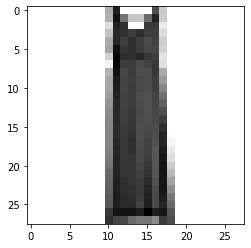

show 20 randomly selected images


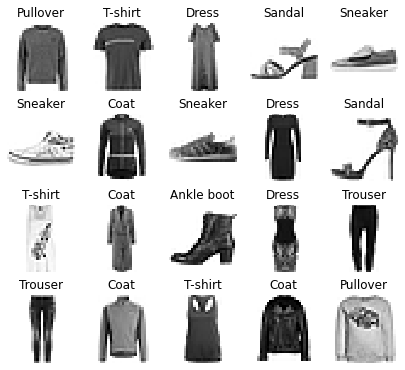

In [11]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print("show the first image")
show_single_image(train_dataset, image_index=0)
print("show 20 randomly selected images")
show_imgs(4, 5, train_dataset, class_names)

### Model Initialization, Loss, Optimizer

In [12]:
# instantiate the model
clf = Multiple_layer_fc_network(input_size=input_size, 
                                num_classes=num_classes,
                                apply_dropout=apply_dropout,
                                dropout_p=dropout_p,
                                apply_bn=apply_bn)
clf.to(device) # move the model to gpu if available
print(clf)

# instantiate the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

apply batch normalization
Multiple_layer_fc_network(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Initialize a dictionary to record training progress

In [13]:
train_state = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

### Train the model
[Model saving and loading](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [14]:
best_val_loss = float('inf')
early_stopping_step = 0

for epoch in range(num_epochs):
    running_train_loss = 0.0 # running loss for every 200 steps during training
    train_loss = 0.0 # accumulated training loss for the entire epoch
    num_train_samples = 0 
    correct = 0
    clf.train() # switch to training mode
    for batch_idx, (images, targets) in enumerate(train_loader):
        # transfer data to gpu if available
        images, targets = images.to(device), targets.to(device)
        #print(images.shape, targets.shape)
        
        # reshape the images to proper shape
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1) #(64, 1, 28, 28)->(64, 28*28)
        
        # forward pass
        preds = clf(images)
        loss = criterion(preds, targets)
        
        # back prop
        optimizer.zero_grad()
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # evaluate performance for each batch
        running_train_loss += loss.item()
        train_loss += loss.item() * batch_size
        num_train_samples += batch_size
        _, pred_labels = torch.max(preds, dim=1) #(64, 10)
        correct += (pred_labels==targets).sum().item()

        # print training stat every 200 steps
        if ((batch_idx+1) % 200==0):
            print(f"[epoch {epoch} step {batch_idx}] running training loss: {running_train_loss/200:.3f}")
            running_train_loss = 0.0
    
    epoch_train_loss= train_loss/num_train_samples
    epoch_train_acc= correct/num_train_samples
            
    # evaluate on the validation set every epoch
    clf.eval() # switch to evaluation mode
    val_loss = 0.0
    num_val_samples = 0 
    correct = 0
    for images, targets in val_loader:
        images, targets = images.to(device), targets.to(device)
        batch_size = images.shape[0]
        images = images.reshape(batch_size, -1)
        preds = clf(images)
        loss = criterion(preds, targets)
        val_loss += loss.item() * images.shape[0]
        num_val_samples += batch_size
        # calculate accuracy
        preds = clf(images)
        _, pred_labels = torch.max(preds, dim=1)
        correct += (pred_labels==targets).sum().item()
    epoch_val_loss= val_loss/num_val_samples
    epoch_val_acc= correct/num_val_samples
    print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}, accuracy: {100*epoch_val_acc:.3f}%")
    
    # update train_state dict
    train_state['train_loss'].append(epoch_train_loss)
    train_state['train_acc'].append(epoch_train_acc)
    train_state['val_loss'].append(epoch_val_loss)
    train_state['val_acc'].append(epoch_val_acc)
    
    # early stopping
    if (epoch_val_loss < best_val_loss):
        best_val_loss = epoch_val_loss
        early_stopping_step = 0
        print(f"current best validation loss: {best_val_loss:.3f}")
        torch.save(clf.state_dict(), saved_model_fn)
        print("=====>save the best model")
    else:
        early_stopping_step += 1
        print(f"validation loss stops decreasing for {early_stopping_step} epoch")
        if (early_stopping_step==early_stopping_criteria):
            print("early stopping criteria reached")
            break
    print("--------------------------------------------")
            

[epoch 0 step 199] running training loss: 0.816
[epoch 0 step 399] running training loss: 0.468
[epoch 0 step 599] running training loss: 0.426
[epoch 0] val loss: 0.389, accuracy: 85.833%
current best validation loss: 0.389
=====>save the best model
--------------------------------------------
[epoch 1 step 199] running training loss: 0.370
[epoch 1 step 399] running training loss: 0.364
[epoch 1 step 599] running training loss: 0.358
[epoch 1] val loss: 0.356, accuracy: 86.892%
current best validation loss: 0.356
=====>save the best model
--------------------------------------------
[epoch 2 step 199] running training loss: 0.321
[epoch 2 step 399] running training loss: 0.329
[epoch 2 step 599] running training loss: 0.316
[epoch 2] val loss: 0.335, accuracy: 87.483%
current best validation loss: 0.335
=====>save the best model
--------------------------------------------
[epoch 3 step 199] running training loss: 0.303
[epoch 3 step 399] running training loss: 0.294
[epoch 3 step 59

### Test the network on the test data

In [15]:
# load the saved best model
clf = Multiple_layer_fc_network(input_size=input_size, 
                                num_classes=num_classes,
                                apply_dropout=apply_dropout,
                                dropout_p=dropout_p,
                                apply_bn=apply_bn)
clf.load_state_dict(torch.load(saved_model_fn))
clf.to(device)

# evaluate on testing set
clf.eval()
test_loss = 0.0
num_test_samples = 0 
correct = 0
for images, targets in test_loader:
    images, targets = images.to(device), targets.to(device)
    batch_size = images.shape[0]
    images = images.reshape(batch_size, -1)
    preds = clf(images)
    loss = criterion(preds, targets)
    test_loss += loss.item() * images.shape[0]
    num_test_samples += batch_size
    # calculate accuracy
    preds = clf(images)
    _, pred_labels = torch.max(preds, dim=1)
    correct += (pred_labels==targets).sum().item()
print(f"testing loss: {test_loss/num_test_samples:.3f}, testing accuracy: {100*correct/num_test_samples:.3f}%")


apply batch normalization
testing loss: 0.347, testing accuracy: 88.350%


### Plot learning curve

In [16]:
def plot_learning_curves(train_hist_df, title):
    num_epoch = train_hist_df.shape[0]
    train_hist_df.plot(figsize=(8, 5), title=title, xticks=range(1, num_epoch+1, 3))
    plt.grid(True)
    ymin, ymax = 0.95 * train_hist_df.values.min(), min(1.1 * train_hist_df.values.max(), 1.0)
    plt.gca().set_ylim(ymin, ymax)
    plt.show()

    train_loss  train_acc  val_loss   val_acc
0     0.539295   0.826042  0.388600  0.858333
1     0.360438   0.869021  0.355512  0.868917
2     0.320065   0.882437  0.335302  0.874833
3     0.297463   0.890813  0.324107  0.879583
4     0.277119   0.897854  0.323320  0.880667
5     0.260424   0.902708  0.354445  0.866083
6     0.247629   0.906583  0.324068  0.881750
7     0.235168   0.912354  0.322182  0.884250
8     0.223936   0.915750  0.333921  0.879833
9     0.213408   0.920312  0.334831  0.882167
10    0.204926   0.922458  0.333512  0.880583
11    0.195672   0.926271  0.321375  0.888667
12    0.187713   0.927562  0.318072  0.888500
13    0.179845   0.932979  0.316089  0.889417
14    0.174841   0.934021  0.329070  0.888500
15    0.167229   0.937833  0.343523  0.888000
16    0.162546   0.939979  0.316599  0.893667
17    0.153921   0.942417  0.362310  0.877333
18    0.152825   0.942833  0.356958  0.882083


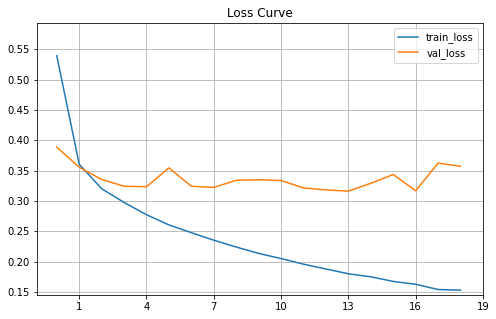

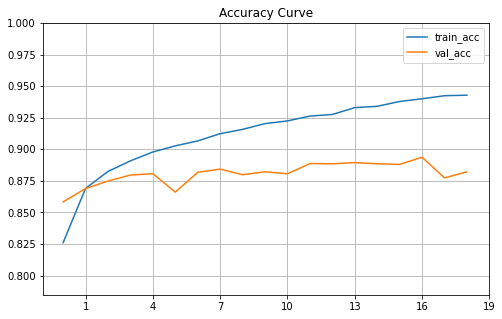

In [17]:
train_state_df = pd.DataFrame(train_state)
print(train_state_df)
plot_learning_curves(train_state_df[['train_loss', 'val_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_acc', 'val_acc']], "Accuracy Curve")